# M1. Actividad 
## Jordana Betancourt Menchaca A01707434

<span style="color:blue; font-size:1.5em;">
Modelación de sistemas multiagentes con gráficas computacionales (Gpo 301)
    
    
Tecnológico de Monterrey Campus Querétaro
</span>


**Dado:**

* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

**Realiza la siguiente simulación:**

* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
  * Si la celda está sucia, entonces aspira.
  * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.

**Deberás recopilar la siguiente información durante la ejecución:**

* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.

In [365]:
#La clase Model para manejar los agentes y la clase Agent para un definir un agente.
from mesa import Agent, Model

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime
from timeit import default_timer as timer

MAXVAL = 10000

In [366]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
    
    
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            #Se toma como movimiento si se puede desplazar a alguna celda vecina
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.model.step_counter += 1
                
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    #print (grid)
    return grid
    
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        self.width = width
        self.height = height
        self.step_counter = 0
        self.timer = 0
        
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        amount = int((width * height) * dirty_cells_percentage)
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
    
    def cells_clean(self):
        #El total de celdas son el alto por el ancho del grid
        total_cells = self.width * self.height
        #Las celdas limpias son todo el grid que no tenga como floor 1 (que es sucio)
        clean_cells = int((total_cells) -np.count_nonzero(self.floor == 1))
        #El porcentaje se saca con regla de tres
        clean_percentage = (clean_cells * 100) / total_cells
        print("Porcentaje de celdas limpias ", clean_percentage, "%")
    
    def total_steps(self):
        print("Pasos dados por todos los agentes: ", self.step_counter)
        
    def total_time(self):
        print("Tiempo de ejecución de la limpieza: ", self.timer, "s")
            
    def step(self):
        """ Ejecuta un paso de la simulación."""
        start = timer()
        self.datacollector.collect(self)
        self.schedule.step()
        end = timer()
        delta_time = end - start
        self.timer += delta_time

In [367]:
# Definimos el tamaño del Grid
WIDTH = 20
HEIGHT = 20

#Definimos el número de celdas iniciales a estar sucias
DIRTY_CELLS_PERCENTAGE = 0.5

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 200

#Definimos el número de agentes que limpiaran
NUM_AGENTS = 50

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = RobotVacuumCleanerModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_CELLS_PERCENTAGE)
i = 1

#Definimos que se siga iterando el modelo hasta que todo esté limpio o ya no haya celdas sucias
while i <= MAX_GENERATIONS and not model.is_all_clean():
    model.step()
    i += 1
    
#Imprimimos el porcentaje de celdas limpias
model.cells_clean()
#Imprimimos el total de pasos que ralizaron los agentes
model.total_steps()
# Imprimimos el tiempo que le tomó correr al modelo o en el que terminó de limpiar celdas
model.total_time()


Porcentaje de celdas limpias  98.5 %
Pasos dados por todos los agentes:  8781
Tiempo de ejecución de la limpieza:  0.3666346999380039  s


In [368]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

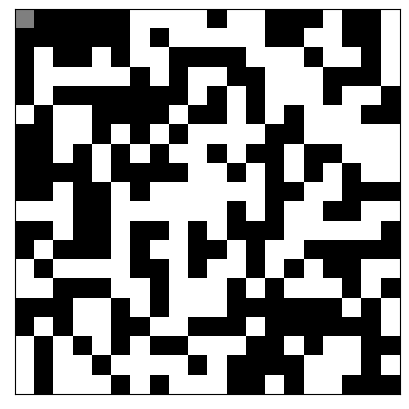

In [369]:
# Graficamos la información usando `matplotlib`

fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [370]:
anim